# RATINGS PREDICTION PROJECT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import io

from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['flipkart1_reviews.csv']))
print(df)

Saving flipkart1_reviews.csv to flipkart1_reviews (1).csv
       Unnamed: 0                                       Review_title  \
0               0                                   Perfect product!   
1               1  Highly recommended but wait for upcoming mi la...   
2               2                                          Fabulous!   
3               3                                          Very Good   
4               4                                    Value-for-money   
...           ...                                                ...   
27105       27105                                      Great product   
27106       27106                                  Worth every penny   
27107       27107                              Mind-blowing purchase   
27108       27108                                            Awesome   
27109       27109                                       Does the job   

                                             Review_text  Ratings  
0      Am

In [4]:
df

,Unnamed: 0,Review_title,Review_text,Ratings
0,0,Perfect product!,Amazing Power in this processer..\n\nYou can d...,5
1,1,Highly recommended but wait for upcoming mi la...,I am civil engineer and i installed SketchUp a...,5
2,2,Fabulous!,"Super work horse\n\nLatest processor, ticks al...",5
3,3,Very Good,Everything is good except display. The process...,4
4,4,Value-for-money,Good laptop form Redmi... performance wise goo...,4
...,...,...,...,...
27105,27105,Great product,Very Nice Watch at This price..... Display is ...,5
27106,27106,Worth every penny,Really osm 👍👍👍 love it\nGo for it\nDisplay qua...,5
27107,27107,Mind-blowing purchase,"Loved the watch, it gives you the premium feel...",5
27108,27108,Awesome,Go for it if you love roud dial watch and your...,5


In [5]:
df.columns

Index(['Unnamed: 0', 'Review_title', 'Review_text', 'Ratings'], dtype='object')

In [6]:
# Droping the index column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df.shape

(27110, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27110 entries, 0 to 27109
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  27110 non-null  object
 1   Review_text   27110 non-null  object
 2   Ratings       27110 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 635.5+ KB


In [9]:
df.rename(columns = {'Review_title':'review_summary', 'Review_text':'full_review','Ratings':'rating'}, inplace = True)
df

,review_summary,full_review,rating
0,Perfect product!,Amazing Power in this processer..\n\nYou can d...,5
1,Highly recommended but wait for upcoming mi la...,I am civil engineer and i installed SketchUp a...,5
2,Fabulous!,"Super work horse\n\nLatest processor, ticks al...",5
3,Very Good,Everything is good except display. The process...,4
4,Value-for-money,Good laptop form Redmi... performance wise goo...,4
...,...,...,...
27105,Great product,Very Nice Watch at This price..... Display is ...,5
27106,Worth every penny,Really osm 👍👍👍 love it\nGo for it\nDisplay qua...,5
27107,Mind-blowing purchase,"Loved the watch, it gives you the premium feel...",5
27108,Awesome,Go for it if you love roud dial watch and your...,5


In [10]:
df.describe()

,rating
count,27110.000000
mean,4.320214
std,1.153164
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
df.isna().sum()

review_summary    0
full_review       0
rating            0
dtype: int64

In [12]:
def clean_text_and_replace(df_column):
    
    # Making all lower case
    df_column = df_column.str.lower()
    
    #Remove new line
    df_column = df_column.str.replace('\n',' ',regex=False)

    
    # Replace email address with 'email'
    df_column = df_column.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' EMAIL_ADDRESS ',regex=True)

    #ReplaceURLs with 'webaddress'
    df_column = df_column.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' WEB_ADDRESS ',regex=True)

    #Replace money symbols with 'moneysymb'
    df_column = df_column.str.replace(r'£|\$',' DOLLER ',regex=True)

    #Replace 10 digit phone number 
    df_column = df_column.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' PHONE_NUMBER',regex=True)

    #Replace numbers with 'numbr'
    df_column = df_column.str.replace(r'\d+(\.\d+)?', ' NUMBER ',regex=True)

    # Remove Punctuation 
    df_column = df_column.str.replace(r'[^\w\d\s]',' ',regex=True)

    #Replace Whitspace between terms with  a single space
    df_column = df_column.str.replace(r'\s+',' ',regex=True)

    #Remove leading and trailing whitespace
    df_column = df_column.str.replace(r'^\s+|\s+?$',' ',regex=True)
    
    # Remove Stop words 
    stop_words = set(stopwords.words('english') + ['u','ur','im','dont','doin','I','numbr','YOU','You','A','If','one','The','page','would','article','talk','like','know','THE','people','get'])
    df_column = df_column.apply(lambda x: ' '.join(
            term for term in x.split() if term not in stop_words 
    ))
    
    
    return df_column

In [13]:
df['review_summary'] = clean_text_and_replace(df['review_summary'])
df['full_review'] = clean_text_and_replace(df['full_review'])

In [14]:
df

,review_summary,full_review,rating
0,perfect product,amazing power processer everything heavy tasks...,5
1,highly recommended wait upcoming mi laptop,civil engineer installed sketchup latest autoc...,5
2,fabulous,super work horse latest processor ticks right ...,5
3,good,everything good except display processor fast ...,4
4,value money,good laptop form redmi performance wise good l...,4
...,...,...,...
27105,great product,nice watch price display awesome built quality...,5
27106,worth every penny,really osm love go display quality really amez...,5
27107,mind blowing purchase,loved watch gives premium feel great watch pri...,5
27108,awesome,go love roud dial watch main intention premium...,5


## **Creating Word Clound For diffrent rattings**

For 1 rattings

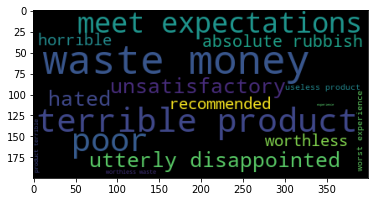

In [15]:
wordCloud = WordCloud(max_words=100).generate(' '.join(
    df['review_summary'][df['rating'] == 1]
))
plt.imshow(wordCloud)

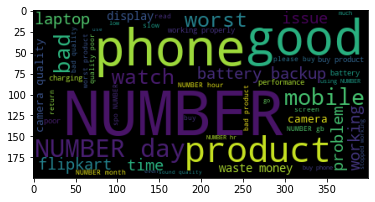

In [16]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['full_review'][df['rating'] == 1]
))
plt.imshow(wordCloud)

For 2 rattings

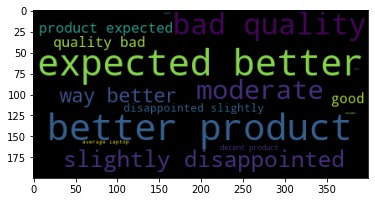

In [17]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['review_summary'][df['rating'] == 2]
))
plt.imshow(wordCloud)

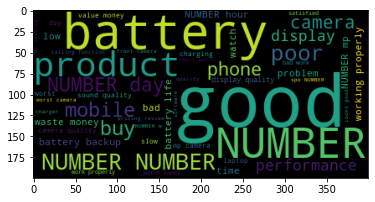

In [18]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['full_review'][df['rating'] == 2]
))
plt.imshow(wordCloud)

For 3 rattings

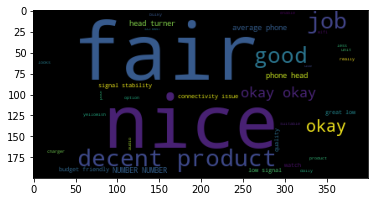

In [19]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['review_summary'][df['rating'] == 3]
))
plt.imshow(wordCloud)

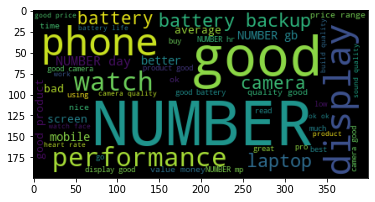

In [20]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['full_review'][df['rating'] == 3]
))
plt.imshow(wordCloud)

For 4 rattings

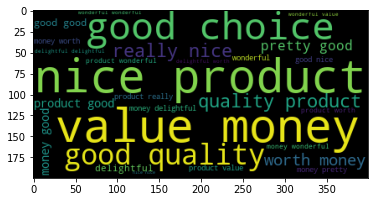

In [21]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['review_summary'][df['rating'] == 4]
))
plt.imshow(wordCloud)

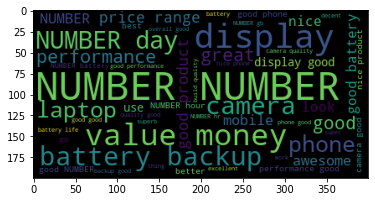

In [22]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['full_review'][df['rating'] == 4]
))
plt.imshow(wordCloud)

For 5 rattings

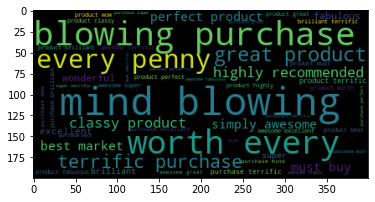

In [23]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['review_summary'][df['rating'] == 5]
))
plt.imshow(wordCloud)

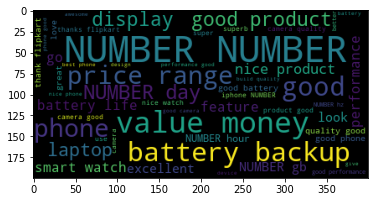

In [24]:
wordCloud = WordCloud(max_words=50).generate(' '.join(
    df['full_review'][df['rating'] == 5]
))
plt.imshow(wordCloud)

In [25]:
# Spliting Dataset 
df.columns

Index(['review_summary', 'full_review', 'rating'], dtype='object')

In [26]:
# Coverting text to Tfid Vector
def tf_idf(column):
    return TfidfVectorizer(min_df=3,smooth_idf=True).fit_transform(column)

In [27]:
# SPliting COlumn
X = df.drop('rating',axis=1)
y = df['rating']

In [28]:
X.columns

Index(['review_summary', 'full_review'], dtype='object')

In [29]:
X_merged = X['review_summary'] +' '+ X['full_review']

In [30]:
X = tf_idf(X_merged)

In [31]:
X.shape

(27110, 5041)

## **Traiing Testing**

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

In [33]:
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    BernoulliNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=3)
]

In [34]:
for model in models:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.20,random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model for:',model)
    print(accuracy_score(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print('-'*100)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model for: LogisticRegression()
0.9260420509037256
[[ 393    1    1    3    3]
 [   8   89    0   10    5]
 [   3    1  243   57   39]
 [   1    0    8  935  206]
 [   0    0    0   55 3361]]
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       401
           2       0.98      0.79      0.88       112
           3       0.96      0.71      0.82       343
           4       0.88      0.81      0.85      1150
           5       0.93      0.98      0.96      3416

    accuracy                           0.93      5422
   macro avg       0.94      0.86      0.89      5422
weighted avg       0.93      0.93      0.92      5422

----------------------------------------------------------------------------------------------------
Model for: KNeighborsClassifier()
0.8731095536702324
[[ 358    6    4   18   15]
 [  13   75    3   12    9]
 [  13    4  246   38   42]
 [   9    2   27  885  227]
 [  14    2   51  179 3170]]
              precision 

In [36]:
# Best modal is random forest so doing Hyper parameter on that 
param_grid = {
    'max_depth' : range(10,14),
    'max_features' : ['auto', 'sqrt'],
    'min_samples_leaf': range(1, 4)
}
gridSearchCV = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,refit=True,verbose=3)
gridSearchCV.fit(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=1;, score=0.639 total time=   2.0s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=1;, score=0.638 total time=   1.9s
[CV 3/5] END max_depth=10, max_features=auto, min_samples_leaf=1;, score=0.639 total time=   1.8s
[CV 4/5] END max_depth=10, max_features=auto, min_samples_leaf=1;, score=0.641 total time=   2.1s
[CV 5/5] END max_depth=10, max_features=auto, min_samples_leaf=1;, score=0.639 total time=   2.5s
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=2;, score=0.640 total time=   1.9s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=2;, score=0.640 total time=   1.9s
[CV 3/5] END max_depth=10, max_features=auto, min_samples_leaf=2;, score=0.639 total time=   1.8s
[CV 4/5] END max_depth=10, max_features=auto, min_samples_leaf=2;, score=0.639 total time=   1.8s
[CV 5/5] END max_depth=10, max_features=auto, min_sample

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(10, 14),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(1, 4)},
             verbose=3)

In [37]:
gridSearchCV.best_params_

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1}

In [38]:
joblib.dump(gridSearchCV.best_estimator_,'randomForestClassifier.obj')

['randomForestClassifier.obj']